# ZZ3 Challenge Deep Learning
## Auteurs: ABDUL-SALAM Sami et TAMAGNAUD Thomas
## Références : 
    - "Image classification from scratch" de fchollet : https://keras.io/examples/vision/image_classification_from_scratch/
    - "A Basis Introduction to Separable Convolutions" de Chi-Feng Wang : https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

### Grâce à l'aide de ChatGPT et des ressources citées ci-dessus

## Setup

In [48]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as tk

from tensorflow.keras import layers
from tensorflow import data

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Transformation de donnée

Technique utilisé pour améliorer la généralisation. Cela permet également d'éviter le sur-apprentissage.

In [49]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),  # Réduire l'angle de rotation
    layers.RandomZoom(0.1),  # Réduire l'amplitude du zoom
    layers.RandomContrast(0.05),  # Réduire l'amplitude du contraste
])

## Datasets

Il faut créer les objets Dataset et standariser les images aux mêmes dimensions

In [50]:
def create_keras_dataset(directory, image_size):
    batch_size = 16

    train_ds, val_ds = tk.utils.image_dataset_from_directory(
        f"datasets/{directory}",
        validation_split=0.3,
        subset="both",
        seed=1342,
        image_size=image_size,
        batch_size=batch_size,
    )
    
    train_ds = train_ds.map(
        lambda x, y: (data_augmentation(x, training=True), y)
    )

    return train_ds, val_ds

size = 128
image_size = (size, size)

# Créer un dataset d'entraînement
train_dataset, validation_dataset  = create_keras_dataset("train", image_size)

Found 14525 files belonging to 3 classes.
Using 10168 files for training.
Using 4357 files for validation.


## Prétraitement des données d'entraînement et de validation

Les données sont encodée de manière conforme avec les 3 classes. Pour optimiser les performances, les datasets sont configurés avec la méthode `prefetch`, qui charge les données en parallèle à l'entraînement pour réduire les temps d'attente.

In [51]:
from tensorflow import data as tf_data

def to_categorical_tensor(y):
    y_one_hot = tf.keras.utils.to_categorical(y, num_classes=3)
    return y_one_hot

def map_function(x, y):
    y = tf.py_function(to_categorical_tensor, [y], tf.float32)
    y.set_shape([None, 3])  # Définir la forme explicite (batch_size, num_classes)
    return x, y

train_dataset = train_dataset.map(map_function)
validation_dataset = validation_dataset.map(map_function)

# Prefetching
train_ds = train_dataset.prefetch(tf_data.AUTOTUNE)
val_ds = validation_dataset.prefetch(tf_data.AUTOTUNE)

## Construction du modèle

Ici, on utilise un modèle présenté dans un exemple de code du site Keras étant une version simplifiée du réseau Xception. Il s'agit d'un réseau de neurones convolutifs, étant adéquat avec la classification d'images. Le modèle Xception est un réseau de neurones convolutifs qui repose sur les convolutions séparables en profondeur. Cette technique divise les convolutions classiques en deux étapes : d'abord une convolution sur les canaux de couleur (profondeur), puis une convolution spatiale. Cela permet de réduire les paramètres du modèle tout en maintenant de bonnes performances pour la classification d'images.

Voici les différentes couches : 

    - Couche d'entree acceptant des images de dimension 'input_shape'.
    - Couche Rescaling normalisant les valeurs des pixels de l'image en les divisant par 255 (passage de valeurs [0, 255] à [0, 1]).
    - Couche Conv2D étant une couche de convolution classique utilisée pour extraire des caractéristiques de l'image, avec un 'stride' valant 2, réduisant la taille de l'image.
    - Couche BatchNormalization permettant de normaliser les activations des couches précédentes.
    - Couche d'activation ReLU (Rectified Linear Unit).
    - Couche SeparableConv2D étant une couche de convolution séparée (ayant pour but de  diviser le noyau de 2 dimensions en deux sous noyaux d'unique dimension, réduisant le nombre d'opérations.).
    - Couche MaxPooling2D réduisant la taille des matrices en sélectionnant les valeurs maximales dans des fenêtre de taille 3x3.
    - Couche GlobalAveragePooling2D ayant le même principe que la couche précédente en calculant la moyenne des valeurs de la fenêtre.
    - Couche Dropout permettant d'éviter le sur-apprentissage en désactivant aléatoirement une fraction des neurones lors de l'entraînement.
    - Couche Dense étant notre couche finale effectuant la classification.


In [58]:
def make_model(input_shape, num_classes):
    inputs = tk.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
   
    units = num_classes

    x = layers.Dropout(0.25)(x)

    outputs = layers.Dense(units, activation="softmax")(x)
    return tk.Model(inputs, outputs)


#model = make_model(input_shape=image_size + (3,), num_classes=3)
#tk.utils.plot_model(model, show_shapes=True)

## Entraînement du modèle

In [53]:
from tensorflow.keras.models import load_model

epochs = 100

model = load_model("best_model.keras")

callbacks = [
    tk.callbacks.ModelCheckpoint(
        "best_model.keras",  # Sauvegarde le modèle avec les meilleurs poids
        monitor="val_acc",  # Surveille l'accuracy sur les données de validation
        save_best_only=True,
        save_weights_only=False
    )
    # tk.callbacks.EarlyStopping(
    #     monitor="val_acc",  # Surveille l'accuracy de validation
    #     patience=5,          # Nombre d'époques sans amélioration avant d'arrêter
    #     restore_best_weights=True  # Restaure les meilleurs poids
    # )
]

model.compile(
    optimizer=tf.optimizers.Adam(3e-4),
    loss=tf.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[tf.metrics.CategoricalAccuracy(name="acc")]
)


model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_dataset,
)

Epoch 1/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 65s 81ms/step - acc: 0.8042 - loss: 0.4701 - val_acc: 0.7429 - val_loss: 0.6188
Epoch 2/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - acc: 0.8130 - loss: 0.4629 - val_acc: 0.7071 - val_loss: 0.7164
Epoch 3/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - acc: 0.8076 - loss: 0.4633 - val_acc: 0.7285 - val_loss: 0.6958
Epoch 4/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 44s 69ms/step - acc: 0.8169 - loss: 0.4404 - val_acc: 0.7767 - val_loss: 0.5085
Epoch 5/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - acc: 0.8180 - loss: 0.4328 - val_acc: 0.7218 - val_loss: 0.6587
Epoch 6/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 44s 68ms/step - acc: 0.8353 - loss: 0.4109 - val_acc: 0.7852 - val_loss: 0.5011
Epoch 7/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 44s 69ms/step - acc: 0.8317 - loss: 0.4129 - val_acc: 0.7787 - val_loss: 0.5077
Epoch 8/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - acc: 0.8277 - loss: 0.4053 - val_acc: 0.7491 - val_loss: 0.6456
Epoch 9/100
636/636 ━━━━━━━━━━━━

## Evaluation des performances du modèle enregistré

In [54]:
model = load_model("best_model.keras")

test_dataset = tk.utils.image_dataset_from_directory(
        "datasets/test",
        image_size=image_size,
        shuffle=True,
    )
test_dataset = test_dataset.map(map_function)

loss, accuracy = model.evaluate(test_dataset)

Found 1643 files belonging to 3 classes.
 8/52 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - acc: 0.7911 - loss: 0.6096

2025-01-23 17:12:10.239921: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - acc: 0.7911 - loss: 0.6522

2025-01-23 17:12:14.156425: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-01-23 17:12:14.232156: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - acc: 0.7869 - loss: 0.6767


## Affichage des images avec leurs prédictions

Vous pouvez relancer l'exécution du code ci-dessous pour afficher les prédictions du modèle sur d'autres images

2025-01-23 18:47:49.201424: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


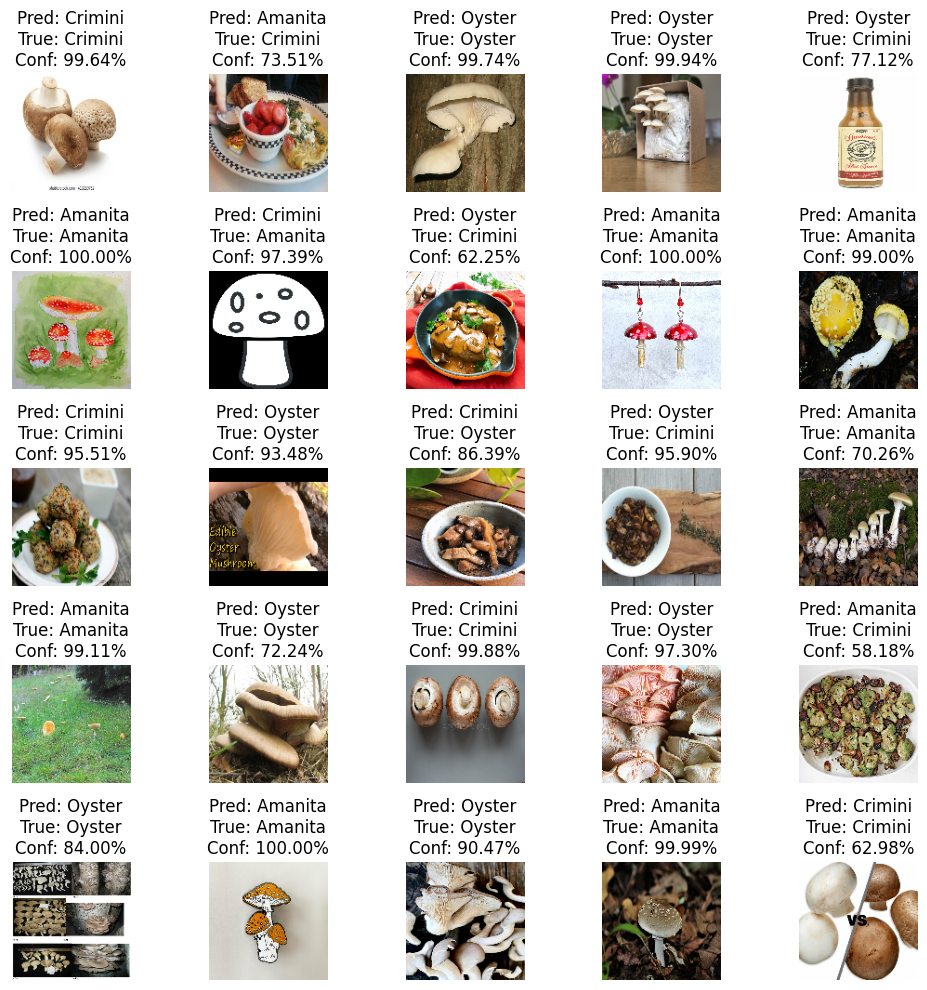

In [60]:
class_mapping = {0: "Amanita", 1: "Crimini", 2: "Oyster"}

for images, labels in test_dataset.take(1):  # Prenons un seul batch
    # Faire une prédiction avec le modèle
    predictions = model.predict(images)
    
    # Trouver la classe prédite pour chaque image
    predicted_classes = np.argmax(predictions, axis=-1)
    true_classes = np.argmax(labels, axis=-1)
    
    # Afficher les images avec la prédiction, la vérité attendue et le pourcentage
    plt.figure(figsize=(10, 10))
    for i in range(min(len(images), 25)):  # Afficher au maximum 25 images
        image = images[i].numpy()  # Convertir l'image en numpy array
        true_label = class_mapping[true_classes[i]]
        predicted_label = class_mapping[predicted_classes[i]]
        
        # Ajouter le pourcentage de confiance (probabilité max)
        confidence = predictions[i][predicted_classes[i]] * 100  # En pourcentage

        # Normaliser les images si elles sont en float avec des valeurs [0, 255]
        if image.max() > 1.0:
            image = image / 255.0

        plt.subplot(5, 5, i + 1)
        if image.shape[-1] == 1:  # Si l'image est en niveaux de gris
            plt.imshow(np.squeeze(image), cmap='gray')
        else:  # Si l'image est RGB
            plt.imshow(image)
        
        # Afficher la prédiction, la vérité attendue et le pourcentage
        plt.title(f"Pred: {predicted_label}\nTrue: {true_label}\nConf: {confidence:.2f}%")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


## Problèmes rencontrés

Il n'a pas été évident de mettre en place les configurations nécessaires au fonctionnement de TensorFlow via GPU (pour finalement avoir certes une détection du GPU sur Windows mais aucune fonction de TensorFlow ne fonctionnait, mis à part les affichages du matériel physique disponible). On avait fini par utiliser un environnement conda avec de vieilles versions de numpy et TensorFlow, malheureusement, cette version de TensorFlow ne permet pas la sauvegarde de modèle au format fichier (mais stocke les informations dans un répertoire). De plus, conda ne permet pas de fournir un `requirements.txt` conforme à tout type d'environnement puisqu'il est nécessaire d'installer des dépendances spécifiques à conda.

Finalement, on est dans un environnement Python 3.10.12 sur WSL2 disposant des configurations pour fonctionner avec le GPU et nous permettant de générer un fichier `requirements.txt` conforme.

## Observation et Suggestion

Avec le modèle tel quel, on s'était basé sur une base de données bien plus faible que le cas présent et on effectuait des transformations trop importantes conduisant à des résultats mauvais.  
En augmentant notre jeu de données et en effectuant des transformations moins importantes, on a amélioré notre cas.

Le modèle n'a pas été entraîné très longtemps, le jeu de test correspond aux données fournies par défaut dans le zip du challenge. Bien évidemment, les données d'entraînement ne contiennent aucune donnée de celles présentes dans le jeu de test afin d'éviter tout biais.

On peut observer dans le graphe ci-dessus que lorsque les images sont claires et que les champignons sont dans leur état naturel, le pourcentage de confiance est élevé (voir au maximum), ce qui semble être normal (fort heureusement). Cependant, lorsque les images sont altérées (filtre de couleur, ...), transformées (plats, ...), ou alors représentent un champignon sans être explicite (T-shirt, mug, ...), il devient évidemment plus compliqué pour notre modèle de prédire le bon cas (dépendant du niveau d'altération). Bien qu'on effectue des transformations minimes dans nos entraînements, on peut observer qu'à certains moments, notre modèle a du mal, d'où le pourcentage de précision ne dépasse pas 80%.

Comme points d'améliorations, il pourrait être intéressant de fournir des données de champignons transformés (comme des plats, T-shirt, etc.) afin que le modèle puisse en apprendre davantage. En effet, notre base de données n'est composée que de champignons dans leur état d'origine. Puis, on pourrait essayer d'autres types de transformations des données comme des filtres de couleur par exemple.